# Initialisation

In [1]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive') 
os.chdir('/content/drive/My Drive/Colab Notebooks/P7_Réalisez des indexations automatiques d’images')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tarfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
from PIL import Image, ImageOps
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn import cluster, metrics
import cv2
import timeit

from skimage.transform import resize
%matplotlib inline
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, VGG16, decode_predictions
from keras.models import Model

# Constantes et fonctions

In [3]:
WIDTH = 224
HEIGHT = 224
STEP = 1000

def plot_at_k(img, k):
    """
    Function to reconstruct and plot image for a given number of components
    """

    ipca = PCA(n_components=k)
    image_recon = ipca.inverse_transform(ipca.fit_transform(img))
    plt.imshow(image_recon.reshape(100, 100), cmap='gray')

# Chargement/nettoyage des images

1000 24.38s
2000 32.53s
3000 40.51s
4000 48.57s
5000 56.70s
6000 64.64s
7000 72.32s
8000 80.29s
9000 88.44s
10000 96.58s
11000 105.07s
12000 113.77s
13000 122.30s
14000 130.53s
15000 139.08s
16000 147.88s
17000 155.86s
18000 163.86s
19000 171.91s
20000 179.98s
20580 185.23s
DF 185.24s


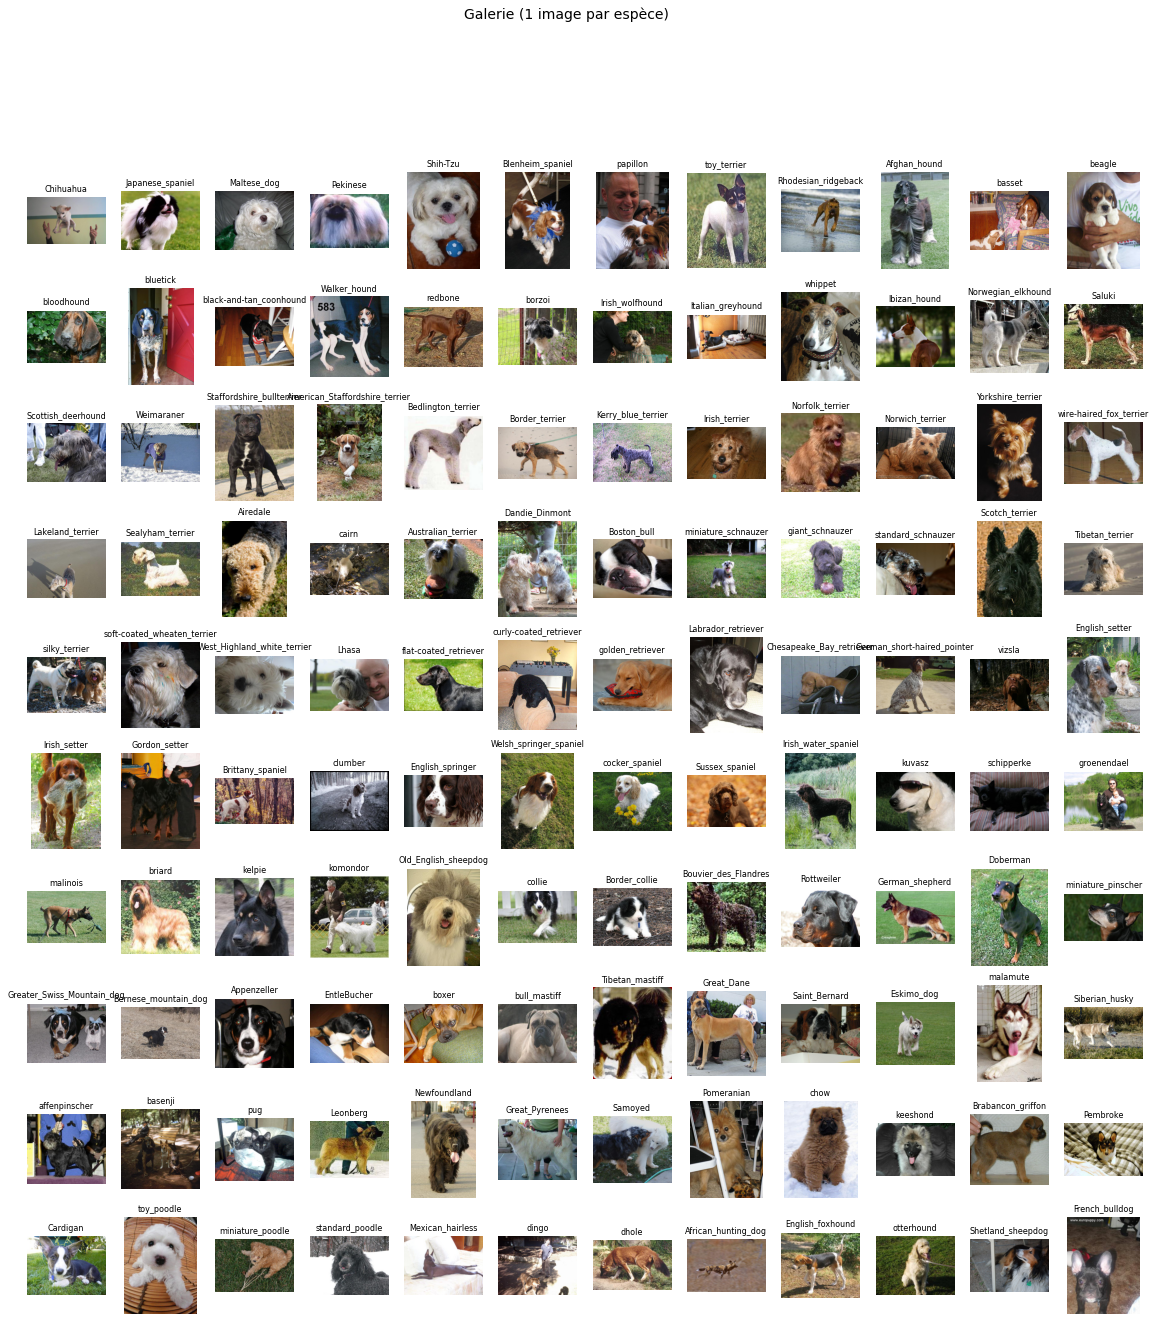

In [4]:
breeds = [] 
tailles = [] 
modes = [] 
temp = []
temp_gray = []
step = 0
nbreeds = 0

fig = plt.figure(figsize=(20, 21))

start_time = timeit.default_timer()

with tarfile.open('images.tar', 'r:tar') as tarFile:
    #tarInfo = tarFile.next()
    for d in tarFile.getmembers():
        if d.isfile():
            last_slash = d.name.rfind('/')
            breed = d.name[d.name.rfind('/', 1, last_slash)+1:last_slash]
            breed = breed[breed.find('-')+1:]
            #img_idx = d.name[last_slash+1:]

            file = tarFile.extractfile(d)
            img = Image.open(file)

            tailles.append(img.size)
            modes.append(img.mode)
            
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Dimensionnement des images 
            img_conv = img.resize((WIDTH, HEIGHT))

            # Correction de l'exposition
            img_conv = ImageOps.autocontrast(img_conv)

            # Correction du contraste
            img_conv = ImageOps.equalize(img_conv)
            #img = cv2.equalizeHist(img)

            # application d'un filtre médian
            img_conv = cv2.medianBlur(np.array(img_conv), 5)

            if breed not in breeds:
                breeds.append(breed)
                nbreeds += 1 
                plt.subplot(10, 12, nbreeds)
                plt.title(breed, fontsize=8)
                plt.suptitle('Galerie (1 image par espèce)', fontsize=14, va='bottom')
                plt.axis('off')
                plt.imshow(img)            

            temp.append([breed, img_conv])
            #temp_gray.append([breed, cv2.cvtColor(img_conv, cv2.COLOR_BGR2GRAY)])

            step  = len(temp) #dogs_df_new.shape[0]
            if step % STEP == 0:
                print("{} {:.2f}s".format(step, timeit.default_timer()-start_time))
                
            #if cpt == STEP:
            #    break

if step % STEP != 0:
    print("{} {:.2f}s".format(step, timeit.default_timer()-start_time))

dogs_df = pd.DataFrame(temp, columns=['breed', 'img'])
#dogs_df_gray = pd.DataFrame(temp_gray, columns=['breed', 'img'])
print("DF {:.2f}s".format(timeit.default_timer()-start_time))

In [ ]:
dogs_df.head()

,breed,img,img_gray,breed_lbl
0,Chihuahua,"[[[27, 29, 62], [27, 29, 62], [28, 30, 62], [2...","[[39, 39, 41, 44, 46, 47, 52, 53, 56, 59, 61, ...",17
1,Chihuahua,"[[[48, 47, 41], [48, 46, 39], [43, 41, 35], [3...","[[45, 40, 34, 26, 24, 20, 19, 19, 19, 20, 22, ...",17
2,Chihuahua,"[[[242, 242, 241], [242, 242, 242], [241, 242,...","[[242, 242, 241, 240, 241, 241, 240, 239, 222,...",17
3,Chihuahua,"[[[191, 179, 189], [183, 172, 181], [115, 121,...","[[178, 132, 109, 121, 124, 138, 131, 137, 132,...",17
4,Chihuahua,"[[[104, 107, 245], [99, 114, 193], [89, 114, 1...","[[146, 118, 103, 107, 145, 162, 144, 78, 58, 5...",17


In [8]:
dogs_df.breed.describe()

count           20580
unique            120
top       Maltese_dog
freq              252
Name: breed, dtype: object

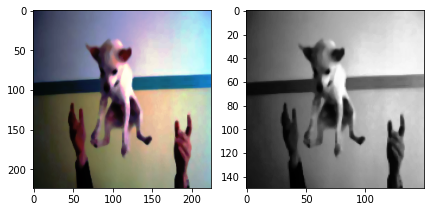

In [ ]:
#fig = plt.figure(figsize=(7, 15))
#plt.subplot(121)
#plt.imshow(dogs_df.img.iloc[0])
#plt.subplot(122)
#plt.imshow(dogs_df.img_gray.iloc[0], cmap='gray')

## Etiquetage des espèces de chiens

In [5]:
breed_lbl = LabelEncoder() 
dogs_df['breed_lbl'] = breed_lbl.fit_transform(dogs_df.breed)

## Back-up dogs_df

In [6]:
with open('OC_DS_P7_dogs_df.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(dogs_df)

In [ ]:
with open('OC_DS_P7_dogs_df.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    dogs_df = unpickler.load()

# Exploration

## Tailles initiales des photos

Text(0, 0.5, 'height')

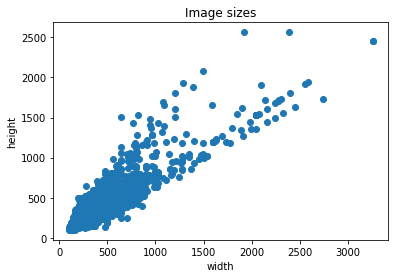

In [ ]:
shapes = np.asarray(tailles)
plt.plot(shapes[:, 0], shapes[:, 1], "o")
plt.title("Image sizes")
plt.xlabel("width")
plt.ylabel("height")

## Modes initiaux

In [ ]:
Counter(modes).most_common()

[('RGB', 20579), ('RGBA', 1)]

## Distribution des espèces

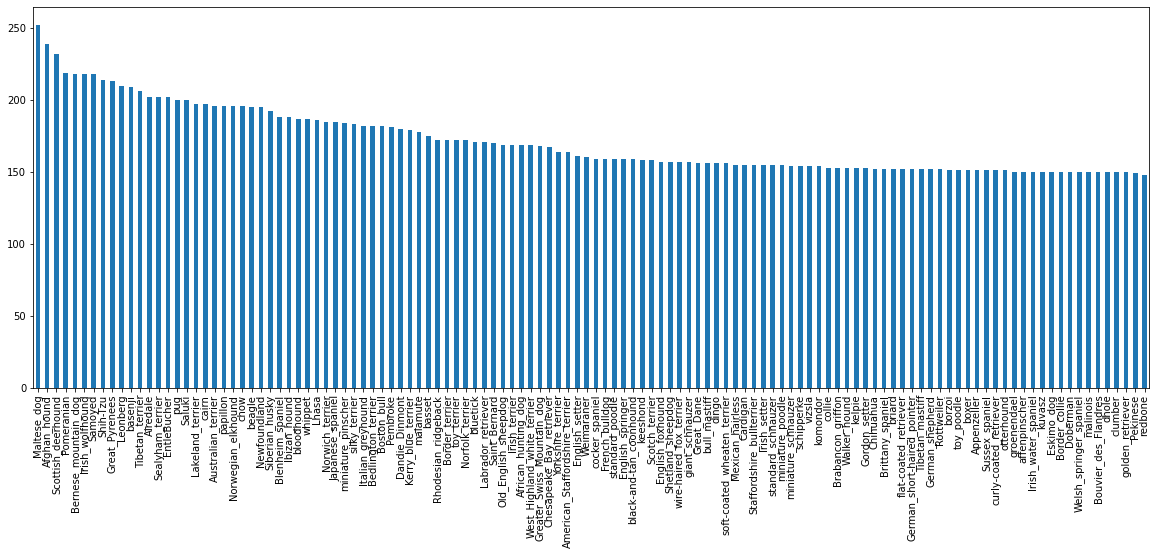

In [ ]:
fig = plt.figure(figsize=(20, 7))
dogs_df['breed'].value_counts().plot.bar()

# Approche standard

## Echantillon de 10000 photos en noir/blanc et normalisation


In [10]:
gray_samples = dogs_df.sample(10000)
gray_samples.shape

(10000, 3)

In [11]:
gray_samples['img'] = [ cv2.cvtColor(cv2.resize(t, (150, 150)), \
                                     cv2.COLOR_BGR2GRAY) \
                       for t in gray_samples['img']]

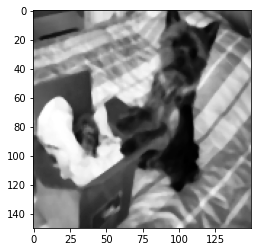

In [12]:
plt.imshow(gray_samples.img.iloc[-1], cmap='gray')

In [13]:
with open('OC_DS_P7_gray_samples.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(gray_samples)

In [4]:
with open('OC_DS_P7_gray_samples.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gray_samples = unpickler.load()

In [5]:
X = np.array(gray_samples.img.values.tolist())
X = X.reshape(-1, X.shape[1] * X.shape[2])
#X_scaled = X
X.shape

(10000, 22500)

In [15]:
with open('OC_DS_P7_X.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(X)

In [ ]:
with open('OC_DS_P7_X.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    X = unpickler.load()

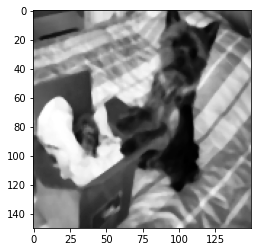

In [16]:
plt.imshow((X[-1]).reshape(150, 150), cmap='gray')

## Feature detection

In [17]:
STEP = 1000
features = []
l = []
w = []
cpt = 0 

orb = cv2.ORB_create(nfeatures=100)  # OpenCV 3 backward incompatibility: Do not create a detector with `cv2.ORB()`.

start_time = timeit.default_timer()

for i in gray_samples.img: 
    
    key_points, descriptor = orb.detectAndCompute(i, None)
    l.append(descriptor.shape[0])
    w.append(descriptor.shape[1])

    #descriptor = descriptor.reshape(-1, 1)
    features.append(descriptor)
    
    cpt += 1
    if cpt % STEP == 0:
        print("{} {:.2f}s".format(cpt, timeit.default_timer()-start_time))

if cpt % STEP != 0:
    print("{} {:.2f}s".format(cpt, timeit.default_timer()-start_time))

print(len(features))

1000 2.10s
2000 3.96s
3000 5.81s
4000 7.68s
5000 9.53s
6000 11.38s
7000 13.22s
8000 15.06s
9000 16.93s
10000 18.77s
10000


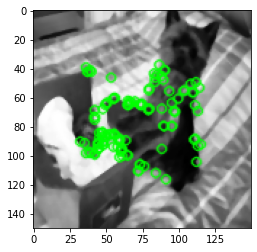

In [19]:
kp_img = cv2.drawKeypoints(gray_samples.img.iloc[-1], key_points, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DEFAULT)
plt.imshow(kp_img)

In [ ]:
start_time = timeit.default_timer()

# Clustering avec kmeans
myclust = cluster.KMeans(init="k-means++", n_clusters=120, random_state=1)
myclust.fit(X_scaled_pca)

print('Durée {:.2f}s'.format(timeit.default_timer()-start_time))

# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_scaled_pca, myclust.labels_))

## Normalisation

In [6]:
X_scaled = X / 255
X.min(), X.max(), X_scaled.min(), X_scaled.max()

(0, 255, 0.0, 1.0)

## Réduction de dimension (PCA)

In [7]:
argmax = []
cpt = 0 
VARIANCE = .95
STEP = 1000

start_time = timeit.default_timer()

pca = PCA(VARIANCE)

pca.fit(X_scaled)

min_features = pca.n_components_
print('PCA min features {} en {:.2f}s'.format(min_features, timeit.default_timer()-start_time))

PCA min features 662 en 1234.48s


Je fixe le nombre de composants à 2000


In [9]:
start_time = timeit.default_timer()

pca = PCA(n_components=2000)
X_scaled_pca = pca.fit_transform(X_scaled)

print('Durée {:.2f}s'.format(timeit.default_timer()-start_time))

X_scaled_pca.shape

Durée 338.02s


(10000, 2000)

In [10]:
with open('OC_DS_P7_X_scaled_pca.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(X_scaled_pca)

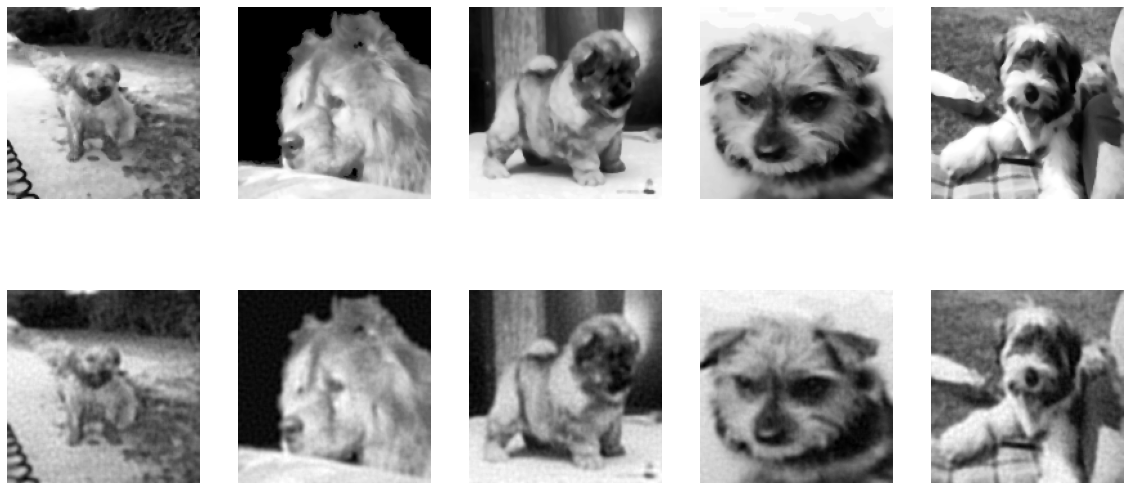

In [11]:
num = 5 
cpt = 0

plt.figure(figsize=(20,20))

for cpt in range(num):

    plt.subplot(4, 5, 1 + cpt + num * (cpt // num))
    plt.axis('off')
    plt.imshow(X_scaled[cpt].reshape(150, 150), cmap='gray')

    plt.subplot(4, 5, 6 + cpt + num * (cpt // num))
    plt.axis('off')
    plt.imshow((pca.inverse_transform(X_scaled_pca[cpt])).reshape(150, 150), cmap='gray')

## Clustering kMeans

In [ ]:
X_scaled_pca = StandardScaler().fit_transform(X_scaled_pca)

In [ ]:
X_scaled_pca = X_scaled_pca/X_scaled_pca.max()

In [ ]:
nb_clusters = len(gray_samples.breed.unique())
nb_clusters

120

best clustering =  5


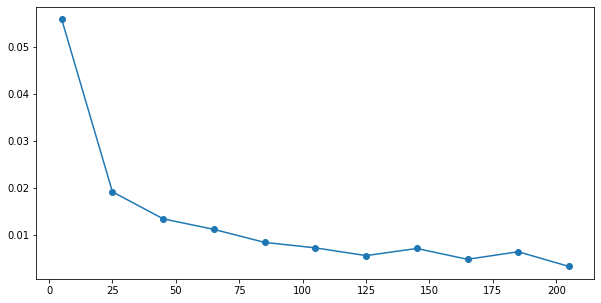

In [ ]:
start_time = timeit.default_timer()

fig = plt.figure(figsize=(10, 5))
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
cluster_range = range(5, 206, 20)
for n in cluster_range:
    myclust = cluster.KMeans(n_clusters=n, random_state=1, init="k-means++")
    myclust.fit(X_scaled_pca)
    print('n_cluster {} {:.2f}s'.format(n, timeit.default_timer()-start_time))
    silhouettes.append(metrics.silhouette_score(X_scaled_pca, myclust.labels_))

plt.plot(cluster_range, silhouettes, marker='o')

best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster)

In [ ]:
start_time = timeit.default_timer()

# Clustering avec kmeans
myclust = cluster.KMeans(init="k-means++", n_clusters=120, random_state=1)
myclust.fit(X_scaled_pca)

print('Durée {:.2f}s'.format(timeit.default_timer()-start_time))

# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_scaled_pca, myclust.labels_))

Durée 152.27s
Silhouette Coefficient: -0.104


In [ ]:
gray_samples = gray_samples.assign(cluster=myclust.labels_)
gray_samples.head()

,breed,img_gray,cluster
17009,Leonberg,"[[148, 63, 59, 62, 79, 104, 107, 132, 206, 184...",35
1400,toy_terrier,"[[46, 44, 44, 44, 44, 44, 45, 45, 46, 48, 48, ...",35
6542,Lakeland_terrier,"[[21, 25, 58, 171, 194, 193, 168, 138, 135, 14...",29
15551,Tibetan_mastiff,"[[155, 155, 166, 167, 169, 170, 169, 169, 172,...",35
16414,affenpinscher,"[[120, 141, 154, 160, 166, 171, 176, 180, 185,...",21


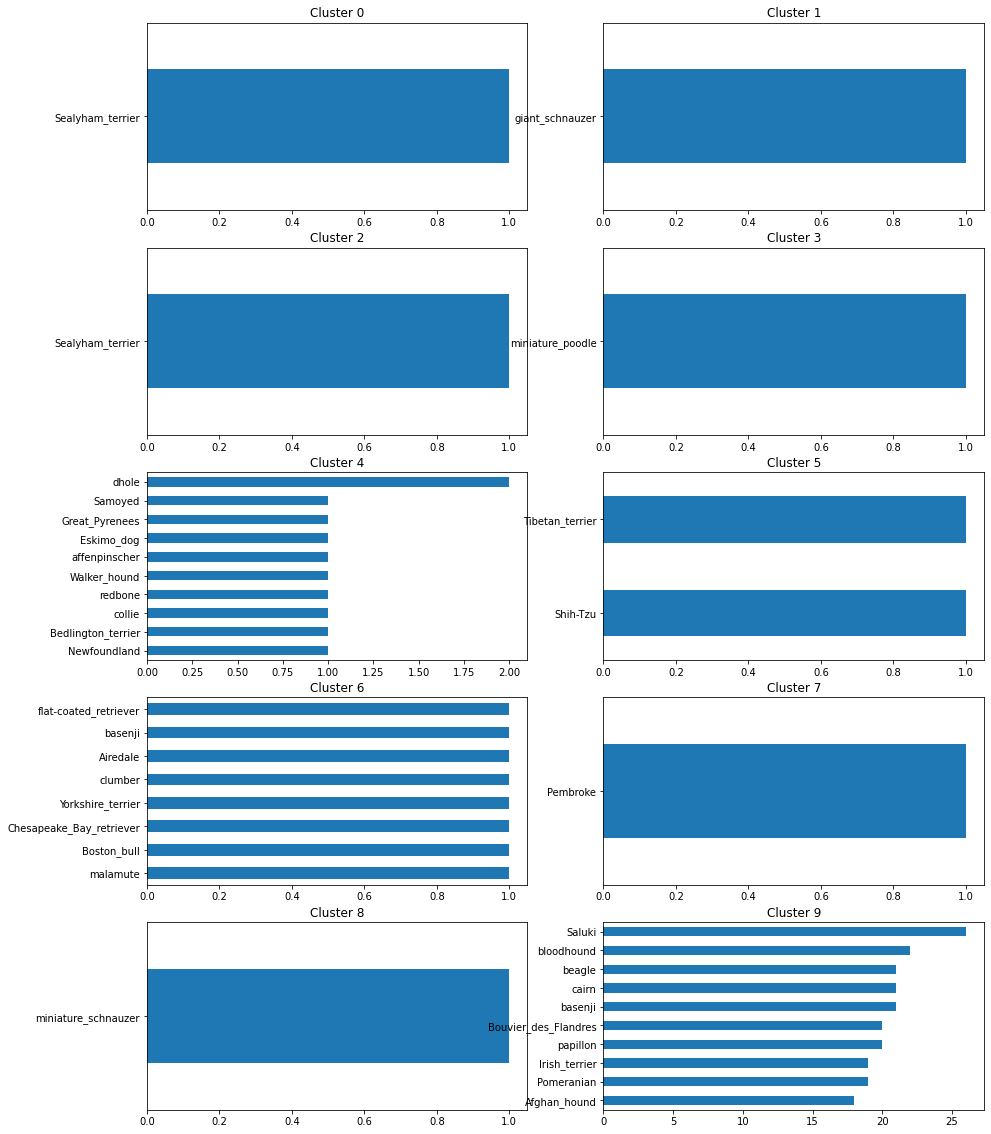

In [ ]:
fig = plt.figure(figsize=(15, 20))

for c in range(10):
    plt.subplot(5, 2, c+1)
    plt.title('Cluster {}'.format(c))
    gray_samples[gray_samples.cluster == c].breed.value_counts(ascending=True)[-10:].plot.barh()

NameError: ignored

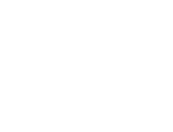

In [ ]:
#Visualisation for clusters = clust
plt.figure(figsize=(20,10))
clust = 2 #enter label number to visualise
num = 20 #num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(4, 6, i) #(Number of rows, Number of column per row, item number)
    plt.axis('off')
    plt.imshow(X_scaled[cluster_index[clust][i]].reshape(150, 150) * 255, cmap='gray')
    
#plt.show()

# CNN

## Séparation train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dogs_df.img, dogs_df.breed_lbl, test_size=0.3)
X_train.shape, X_test.shape

((14406,), (6174,))

In [ ]:
base_model = VGG16()

553467904/553467096 [==============================] - 5s 0us/step


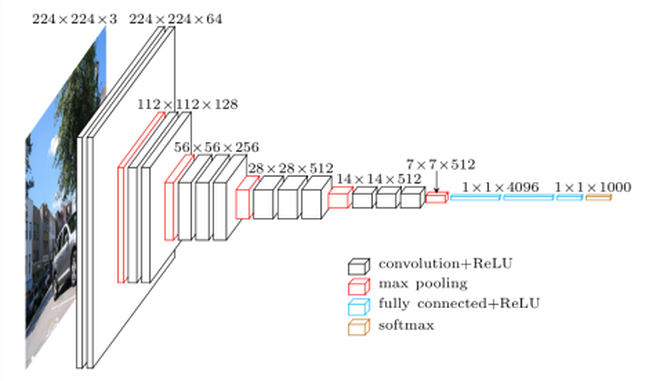

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Base line

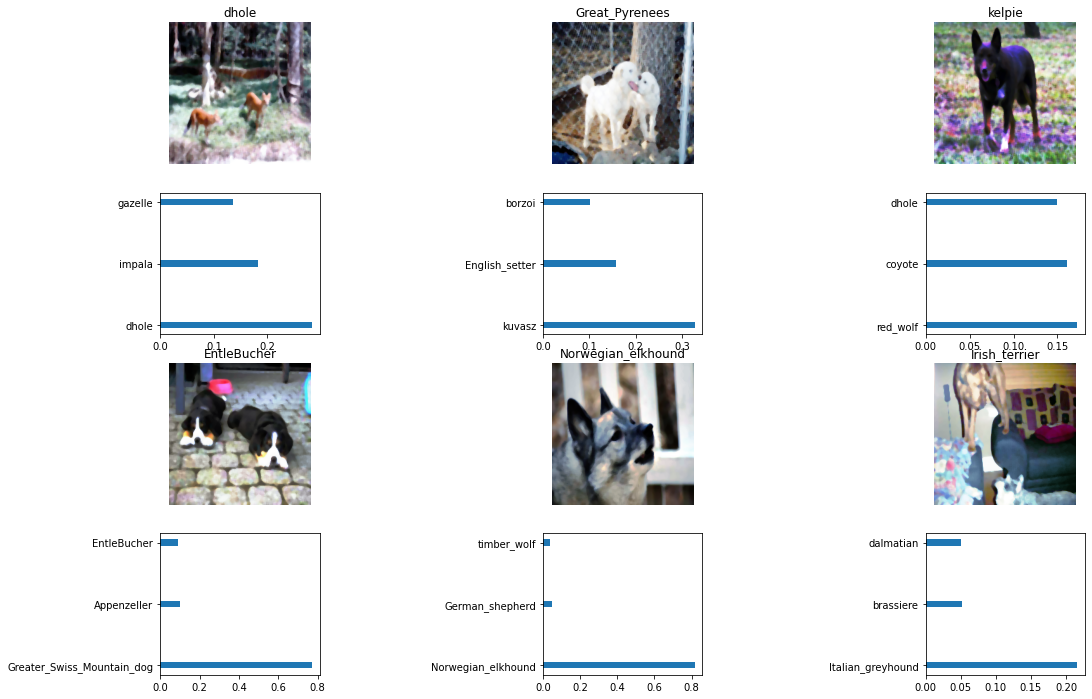

In [ ]:
temp = dogs_df.sample(6) 
fig = plt.figure(figsize=(20, 12))
cpt = 0 

for i, v in temp.iterrows(): 
    cpt += 2 

    img = v.img
    img_vgg = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img_vgg = preprocess_input(img_vgg)  # Prétraiter l'image comme le veut VGG-16

    y = base_model.predict(img_vgg)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)
    pred = decode_predictions(y, top=3)[0]

    plt.subplot(4, 6, cpt + 6 * np.floor(cpt/7))
    plt.axis('off')
    plt.title(v.breed)
    plt.imshow(img)

    plt.subplot(4, 6, cpt + 6 * (1 + np.floor(cpt/7)))
    plt.barh([w[1] for w in pred], [w[2] for w in pred], height=.1)
    # Afficher les 3 classes les plus probables
    #print('Top 3 :', decode_predictions(y, top=3)[0])

## Transfer learning

J'entraine seulement les couches les plus hautes (fine-tunning partiel)

In [ ]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [ ]:
#Generator
def generator(df):
    while 1:
        for i, v in df.iterrows():
            img = v['img']
            #x = image.img_to_array(img)
            #x = np.expand_dims(x, axis=0)
            x = preprocess_input(img)
            #y = df.iloc[i]['breed']
            #y = onehot.transform(y).toarray()
            #print(img.shape,np.array([y]).shape)
            yield (x, y_train[i])
                    
gen = generator(df)

In [ ]:
X_pred = model.predict((X_train, y_train))

ValueError: ignored